# NST 
Generando imágenes con distintos niveles de detalle en el estilo. En concreto se usan los 5 niveles "clásicos" de menos profundidad a mas profundidad. Los niveles se van acumulando. Además se normalizan los pesos del estilo y del contenido para que sean selecionables. 

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
path_GTA = "/content/drive/MyDrive/GTA/"
path_Reales = "/content/drive/MyDrive/Reales/"
path_Simulaciones = "/content/drive/MyDrive/Simulaciones/"

In [ ]:
images_GTA = os.listdir(path_GTA)
images_Reales = os.listdir(path_Reales)
images_Simulaciones = os.listdir(path_Simulaciones)

In [ ]:
content_image = PIL.Image.open(path_GTA + images_GTA[0])
style_image = PIL.Image.open(path_Reales + images_Reales[0])

#content_image = PIL.Image.open('content_image.png')
#style_image = PIL.Image.open('style_image.png')

Imsize = 200

In [ ]:
content_image = np.asarray(content_image.resize((Imsize,Imsize)))
style_image = np.asarray(style_image.resize((Imsize,Imsize)))

In [ ]:
content_image = content_image[:,:,0:3].astype(np.float32)/255
style_image = style_image[:,:,0:3].astype(np.float32)/255

style_image.shape

(200, 200, 3)

In [ ]:
content_image = np.expand_dims(content_image,0)
style_image = np.expand_dims(style_image,0)
content_image.shape

(1, 200, 200, 3)

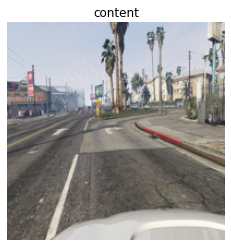

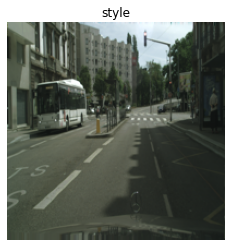

In [ ]:
plt.figure()
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('content')
plt.show()

plt.figure()
plt.imshow(style_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('style')
plt.show()

## Construir modelo 

### Construye el modelo 

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model
    

In [ ]:
#vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#vgg.summary()

### Calcular estilo 

In [ ]:
def gram_matrix(input_tensor):
    result = tf.math.reduce_mean(input_tensor, [1,2])
    #input_shape = tf.shape(input_tensor)
    #num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result#/(num_locations)


### Extraer estilo y contenido 

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


### función de pérdidas

In [ ]:
def style_content_loss(outputs,style_weight,content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    #style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
    #                       for name in style_outputs.keys()])
    #style_loss *= style_weight 

    style_loss = [style_weight*tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()]

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight 
    loss = style_loss + content_loss
    
    return loss, style_loss, content_loss


In [ ]:
def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# BUCLE

In [ ]:
import timeit


In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_layers_ori = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

content_layers = ['block5_conv2'] 

In [ ]:
STYLE_WEIGHT = 100
CONTENT_WEIGHT = 0.5
Nepochs = 20000
muestra_cada = 200

Testing the statistics size

In [ ]:
#style_layers = style_layers_ori[0:5]#layer]
#extractor = StyleContentModel(style_layers, content_layers)
#aa = extractor(content_image)
#aa['style']['block1_conv1']

80150528/80134624 [==============================] - 1s 0us/step


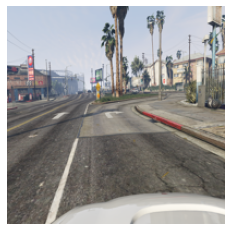

2.5507813e-08 2.5507813e-08 0.0
0.31453088 0.0 0.31453088
99.99999 99.99999 0.0
0.5 0.0 0.5
1 0 99.99833 99.99833 3.7242286e-11
Time:  1.614135403000006
1 200 97.070496 97.07038 0.000116374795
Time:  8.098862158000003
1 400 92.31494 92.31413 0.00081038044
Time:  14.490482385999996
1 600 86.890724 86.888405 0.0023189927
Time:  20.894606436000004
1 800 81.24194 81.23745 0.0044964096
Time:  28.858859179999996
1 1000 75.597694 75.590645 0.0070469044
Time:  35.407392345999995
1 1200 70.09885 70.088905 0.009944868
Time:  41.90546644
1 1400 64.821526 64.80839 0.013140361
Time:  48.301557801
1 1600 59.8046 59.788048 0.016551083
Time:  54.75745291999999
1 1800 55.0695 55.049362 0.020137243
Time:  61.22337732799997
1 2000 50.627018 50.603165 0.023854958
Time:  67.61232283700002
1 2200 46.47802 46.450363 0.02765571
Time:  73.98888417799998
1 2400 42.617455 42.586006 0.031447474
Time:  80.30017710699997
1 2600 39.03649 39.001213 0.0352769
Time:  86.71636578599998
1 2800 35.726208 35.68711 0.039096

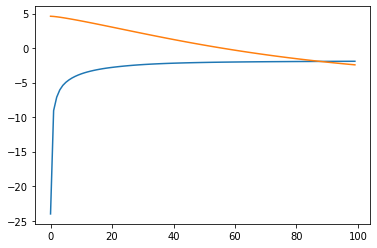

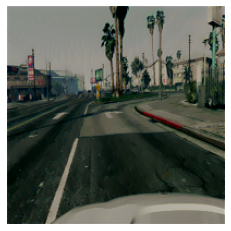

style_weight: 0.19601837479472367 content_weight: 0.00015896690371952372
['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [ ]:
for layer in np.arange(1,2):#6):

    style_layers = style_layers_ori[0:5]#layer]

    extractor = StyleContentModel(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    #image = tf.Variable(content_image.copy())
    image = tf.Variable(content_image.copy())

    plt.figure()
    plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
    plt.show()


    # WEIGHTS FIRST GUESS
    style_weight_FG=5*1e-11
    content_weight_FG=1e-4

    loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight_FG,content_weight_FG)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
    loss_style = np.array(style_loss[0])

    loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight_FG,content_weight_FG)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
    loss_content = np.array(content_loss)

    # WEIGTHS DEFINITION
    style_weight= style_weight_FG * STYLE_WEIGHT/loss_style
    content_weight= content_weight_FG * CONTENT_WEIGHT/loss_content

    # Certify Weights
    loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight,content_weight)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

    loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight,content_weight)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

    @tf.function()  # Precompile
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs,style_weight,content_weight)

        grad = tape.gradient(loss[1][0], image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    L_cont = np.array([])
    L_style = np.array([]) 

    start = timeit.default_timer()
    for n in range(0,Nepochs):
        train_step(image)
        
        if np.mod(n,muestra_cada)==0:
            outputs = extractor(image)
            loss, style_loss, content_loss = style_content_loss(outputs,style_weight,content_weight)
            
            L_cont = np.append(L_cont,np.array(content_loss))
            L_style = np.append(L_style,np.array(style_loss[0]))

            print(layer, n, np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
            
            stop = timeit.default_timer()
            print('Time: ', stop - start) 

    # RESULTS
    # Curvas
    plt.figure()
    plt.plot(np.log(L_cont))
    plt.plot(np.log(L_style))
    plt.show()

    # Resultados
    plt.figure()
    plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
    plt.show()

    # Keep track
    print('style_weight: ' + str(style_weight) + ' content_weight: ' + str(content_weight))
    print(style_layers)

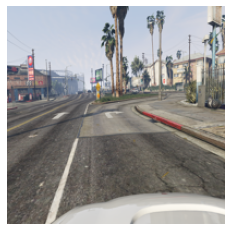

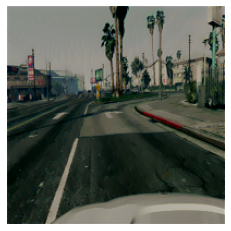

In [ ]:
plt.figure()
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.show()
plt.figure()
plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.show()

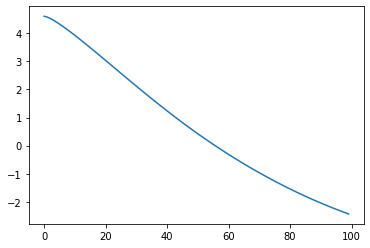

In [ ]:
    # Curvas
    plt.figure()
    #plt.plot(np.log(L_cont[20:]))
    plt.plot(np.log(L_style[0:]))
    plt.show()